In [1]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [1]:
from datasets.noised import DemosaicDataset

In [2]:
import torch
from torchvision import transforms

train_data_dir = "/home/safin/datasets/CASIA_BM3D_CFA/"
transform = transforms.Compose([
                         transforms.ToTensor()
                     ])
noised_dataset = DemosaicDataset(train_data_dir, transform=transform)
#     dataset_train = torchvision.datasets.ImageFolder(train_data_dir, transform=transform)
dataloader_train = torch.utils.data.dataloader.DataLoader(noised_dataset, shuffle=True, batch_size=8, pin_memory=True, num_workers=32)

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import math, random
from PIL import Image

def bilinear(y):
    r""" Initialize with bilinear interpolation"""
    F_r = torch.FloatTensor([[1,2,1],[2,4,2],[1,2,1]])/4
    F_b = F_r
    F_g = torch.FloatTensor([[0,1,0],[1,4,1],[0,1,0]])/4
    bilinear_filter = torch.stack([F_r,F_g,F_b])[:,None]
    if y.is_cuda:
        bilinear_filter = bilinear_filter.cuda()
    res = F.conv2d(y, bilinear_filter,padding=1, groups=3)
    return res

def linrgb_to_srgb(img):
    """ Convert linRGB color space to sRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
#     assert img.dtype in [np.float32, np.float64]
    if isinstance(img, np.ndarray):
        img = img.copy()
    elif isinstance(img, torch.Tensor):
        img = img.clone()
    mask = img <= 0.0031308
    img[~mask] = (img[~mask]**(1/2.4))*(1.055) - 0.055
    img[mask] = img[mask] * 12.92
    return img

def srgb_to_linrgb(img):
    """ Convert sRGB color space to linRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
#     assert img.dtype in [np.float32, np.float64] 
    if isinstance(img, np.ndarray):
        img = img.copy()
    elif isinstance(img, torch.Tensor):
        img = img.clone()
    mask = img <= 0.04045
    img[~mask] = ((img[~mask]+0.055)/1.055)**2.4
    img[mask] = img[mask] / 12.92
    return img

def generate_mask(im_shape, pattern='RGGB'):
    if pattern == 'RGGB':
        # pattern RGGB
        r_mask = torch.zeros(im_shape)
        r_mask[0::2, 0::2] = 1

        g_mask = torch.zeros(im_shape)
        g_mask[::2, 1::2] = 1
        g_mask[1::2, ::2] = 1

        b_mask = torch.zeros(im_shape)
        b_mask[1::2, 1::2] = 1

        mask = torch.zeros((3,) + im_shape)
        mask[0, :, :] = r_mask
        mask[1, :, :] = g_mask
        mask[2, :, :] = b_mask
        return mask

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

M = generate_mask((112,96)).cuda()

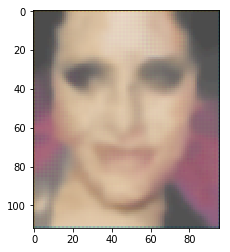

In [6]:
mosaic = noised_dataset[2][0].unsqueeze(0)

denoised_img = bilinear(M*mosaic)/255
denoised_img = linrgb_to_srgb(denoised_img)
img = denoised_img/0.6
img = img.clamp(0,255)
img = img.squeeze(0)
img = img.permute(1,2,0).numpy()

plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


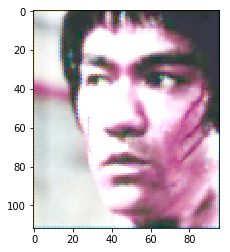

In [7]:
import torchvision
dataset_train = torchvision.datasets.ImageFolder(train_data_dir, transform=transform)
data_x = dataset_train[2][0]
data_x = M * data_x
data_x = data_x.unsqueeze(0)
data_x = linrgb_to_srgb(bilinear(data_x))
data_x = data_x.squeeze(0).permute(1,2,0)
data_x = data_x.numpy()
data_x = data_x/0.6
plt.imshow(data_x)

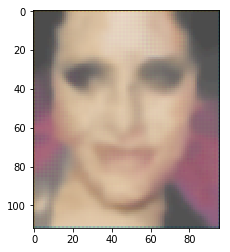

In [8]:
img = noised_dataset[2][0]
img = generate_mask((112,96)) * img
img = linrgb_to_srgb(bilinear(img.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy()/255)/0.6
plt.imshow(img)

In [5]:
val_bayer_noised_data_dir = "/home/safin/datasets/lfw/lfw-sphereface_noised_bayer/"
val_clean_data_dir = "/home/safin/datasets/lfw/lfw-sphereface/"

In [6]:
import torchvision
from torchvision import transforms
transform = transforms.ToTensor()
dataset_bayer_noised_val = torchvision.datasets.ImageFolder(val_bayer_noised_data_dir, transform=transform)
dataset_clean_val = torchvision.datasets.ImageFolder(val_clean_data_dir, transform=transform)

In [7]:
import numpy as np
lfw_idx = np.load("/home/safin/datasets/lfw/noised_indx.npy")

In [11]:
from MMNet_TBPTT import *
from networks.denoise.pydl import ResNet_Den
import torch 
from utils import freeze_model

torch.backends.cudnn.benchmark = True 

denoiser_faceid_only = ResNet_Den(5, weightnorm=True)
denoiser_faceid_only = denoiser_faceid_only.cuda()
freeze_model(denoiser_faceid_only)

max_iter = 5
mmnet_faceid_only = MMNet(denoiser_faceid_only, max_iter=max_iter)
mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/joint_08.05_facefr_only_faceloss/mmnet/weights_19"
mmnet_faceid_only.load_state_dict(torch.load(mmnet_ckpt_path, map_location=lambda storage, loc: storage))
mmnet_faceid_only = mmnet_faceid_only.cuda()


denoiser = ResNet_Den(5, weightnorm=True)
denoiser = denoiser.cuda()
freeze_model(denoiser)

max_iter = 5
mmnet = MMNet(denoiser, max_iter=max_iter)
mmnet_ckpt_path = "/home/safin/FaceReID/ckpt/joint_08.05_facefr/mmnet/weights_19"
mmnet.load_state_dict(torch.load(mmnet_ckpt_path, map_location=lambda storage, loc: storage))
mmnet = mmnet.cuda()



In [27]:
denoised_img.max()

169.87616

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AVG PSNR = 23.3836


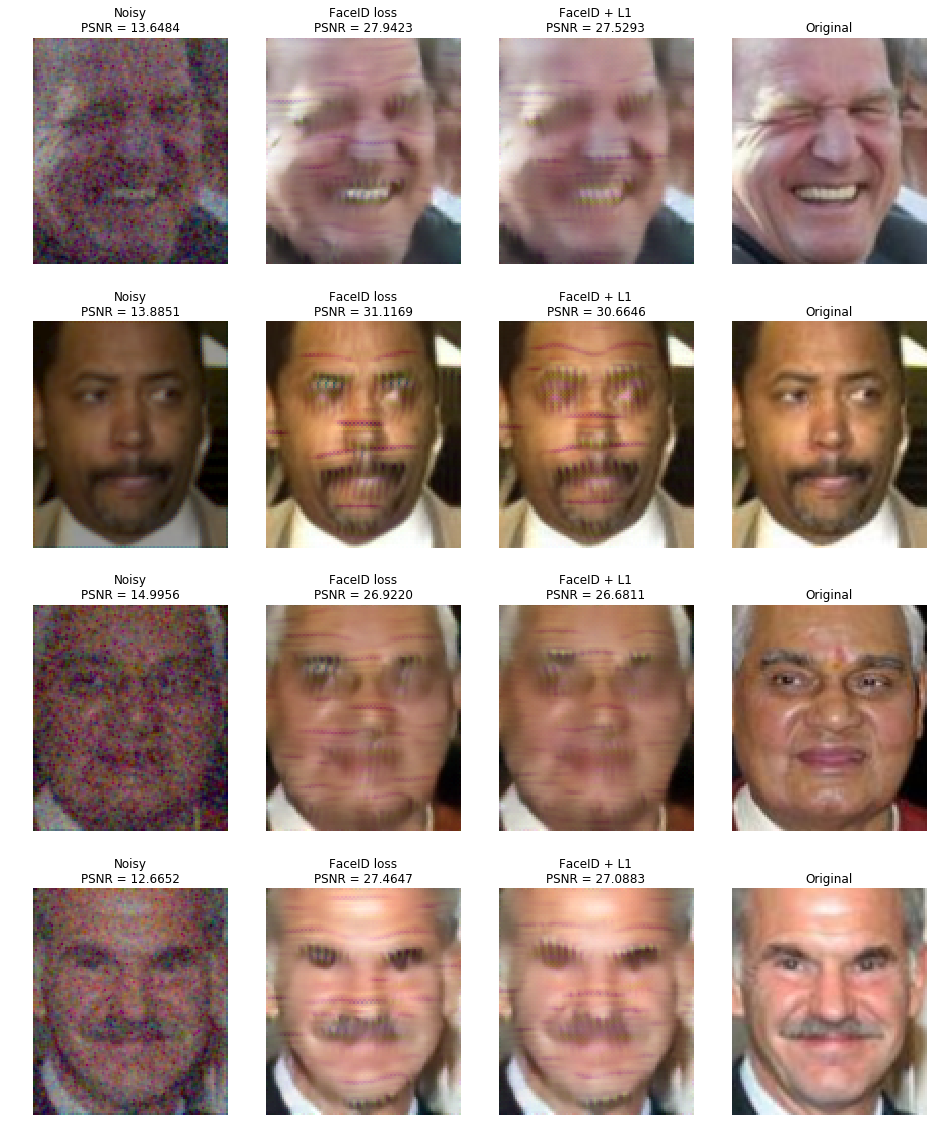

In [12]:
from loss import PSNR

fig_w = 16
fig_h = 20
fig=plt.figure(figsize=(fig_w, fig_h))
rows = 4
columns = 4

psnr_arr = []
for i in range(rows):
    cur_idx = lfw_idx[i]

    imgs_bayer_noisy, _ = dataset_bayer_noised_val[cur_idx]
    A_bayer_noisy = linrgb_to_srgb(bilinear(imgs_bayer_noisy.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())
    A_clean = dataset_clean_val[cur_idx][0].permute(1,2,0).numpy()

    
    fig.add_subplot(rows, columns, 1+i*columns)
    plt.imshow(A_bayer_noisy)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(A_bayer_noisy).unsqueeze(0), torch.from_numpy(A_clean).unsqueeze(0))
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
    psnr_arr.append(cur_psnr)
    plt.title("Noisy\nPSNR = %.4f" % cur_psnr)
    
    denoised_img_faceid_only = mmnet_faceid_only.forward_all_iter(255*imgs_bayer_noisy.unsqueeze(0).cuda(), M, init=False, noise_estimation=True)
    denoised_img_faceid_only = denoised_img_faceid_only.data.cpu().squeeze(0).permute(1,2,0).numpy()/255
#     denoised_bayer = linrgb_to_srgb(bilinear(denoised_bayer.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())
    fig.add_subplot(rows, columns, 1+i*columns+1)
    plt.imshow(denoised_img_faceid_only/0.6)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(denoised_img_faceid_only/0.6).unsqueeze(0), torch.from_numpy(A_clean).unsqueeze(0))
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
    psnr_arr.append(cur_psnr)
    plt.title("FaceID loss\nPSNR = %.4f" % cur_psnr)
    
    denoised_img = mmnet.forward_all_iter(255*imgs_bayer_noisy.unsqueeze(0).cuda(), M, init=False, noise_estimation=True)
    denoised_img = denoised_img.data.cpu().squeeze(0).permute(1,2,0).numpy()/255
#     denoised_bayer = linrgb_to_srgb(bilinear(denoised_bayer.unsqueeze(0)).squeeze(0).permute(1,2,0).numpy())
    fig.add_subplot(rows, columns, 1+i*columns+2)
    plt.imshow(denoised_img/0.6)
    plt.axis('off')
    cur_psnr = PSNR(torch.from_numpy(denoised_img/0.6).unsqueeze(0), torch.from_numpy(A_clean).unsqueeze(0))
#         cur_psnr = psnr(torch.from_numpy(noised).unsqueeze(0), torch.from_numpy(gt).unsqueeze(0), 1.)
    psnr_arr.append(cur_psnr)
    plt.title("FaceID + L1\nPSNR = %.4f" % cur_psnr)

    fig.add_subplot(rows, columns, 1+i*columns+3)
    plt.imshow(A_clean)
    plt.axis('off')
    plt.title("Original")

    i += 1
print("AVG PSNR = %.4f" % np.mean(psnr_arr))

In [39]:
denoised_bayer.max()/0.6

1.0153627395629883